# PDE-FIND za klasični harmonijski oscilator

Vinko Dragušica, 2022.

Predstavljen je kod koji pomoću modula PDE-FIND iz danih podataka otkriva jednadžbu koja opisuje dinamiku klasičnog harmonijskog oscilatora za $\omega=2$.
$$
u_{tt} + \omega^2u = 0
$$

In [1]:
%matplotlib inline
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import sys; sys.path.append('../')
from PDE_FIND_CM import *
import itertools

In [2]:
import pandas
df = pandas.read_csv('../Datasets/HarmOscPodatci.csv', skiprows=1, header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.0,0.100838,0.200649,0.298414,0.393137,0.483852,0.569634,0.64961,0.722963,0.788945,...,0.327701,0.23076,0.131467,0.030834,-0.070114,-0.170347,-0.268843,-0.364599,-0.456637,-0.544021


In [3]:
u = df.to_numpy()
x = [0]
t = np.linspace(0,5,100)
dt = t[1]-t[0]
#dx = x[1]-x[0]

Text(0, 0.5, 'u(t)')

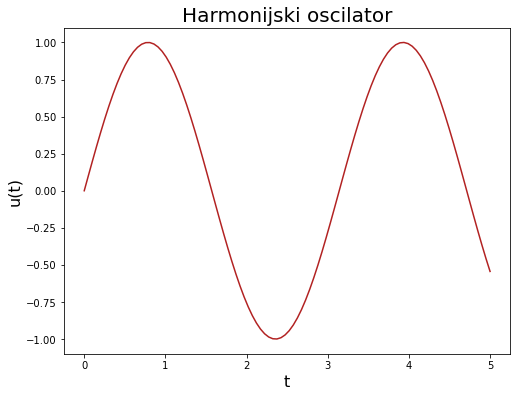

In [4]:
fig1 = plt.figure(figsize=(8,6))
plt.plot(t,u[0,:],color='firebrick')
plt.title('Harmonijski oscilator', fontsize = 20)
plt.xlabel('t', fontsize = 16)
plt.ylabel('u(t)', fontsize = 16)

## Konstruiramo $\Theta (U)$ i računamo $U_t$:

Konstruiramo funkcije koje će se nalaziti u $\Theta$. Također specificiramo njihove opise i na kraju pomoću build_Theta konstruiramo $\Theta$ koji ćemo koristiti kasnije. <br>
time_diff i space_diff izračunati su pomoću metode konačnih razlika (funkcija FiniteDiff()).

Ispisana je lista funkcija kandidata za PDJ. Svaka od ispisanih funkcija ekvivalentna je stupcu u $\Theta (U)$.

In [5]:
m = len(x)
n = len(t)

ut = np.zeros((m,n), dtype=np.complex64)
utt = np.zeros((m,n), dtype=np.complex64)
sin_t = np.zeros((m,n), dtype=np.complex64)
cos_t = np.zeros((m,n), dtype=np.complex64)
exp_t = np.zeros((m,n), dtype=np.complex64)

for i in range(m):
    ut[i,:] = FiniteDiff(u[i,:], dt, 1)
    utt[i,:] = FiniteDiff(u[i,:], dt,2) # koristi se kasnije kod funkcije TrainSTRidge
    sin_t[i,:] = np.sin(t)
    cos_t[i,:] = np.cos(t)
    exp_t[i,:] = np.e**t
    
ut = np.reshape(ut, (n*m,1), order='F')
utt = np.reshape(utt, (n*m,1), order='F')

X_ders = np.hstack([np.ones((n*m,1)),ut])
X_data = np.hstack([np.reshape(u, (n*m,1), order='F'),
                    np.reshape(sin_t, (n*m,1), order='F'),
                    np.reshape(cos_t, (n*m,1), order='F'),
                    np.reshape(exp_t, (n*m,1), order='F')])
derivatives_description = ['','u_{t}']

X, descr = build_Theta(X_data, X_ders, derivatives_description, P=1, data_description = ['u','sin(t)','cos(t)','e^t'])
descr

['',
 'u_{t}',
 'e^t',
 'cos(t)',
 'sin(t)',
 'u',
 'e^tu_{t}',
 'cos(t)u_{t}',
 'sin(t)u_{t}',
 'uu_{t}']

## Računamo $\xi$:

TrainSTRidge dijeli podatke na dio za trening (80% ukupnih podataka) i dio za validaciju (20% ukupnih podataka). Algoritam traži optimalnu vrijednost za varijablu tol (tolerancija ispod koje zanemarujemo varijablu) i odabire toleranciju provjerom na validacijskom skupu, uključujući i $\ell^0$ penalizaciju za $\xi$ u funkciji gubitka.

In [6]:
# Solve with STRidge
w = TrainSTRidge(X,utt,10**-5,0.1)
print("PDJ dobivena pomoću STRidge:")
print_pde(w, descr)

PDJ dobivena pomoću STRidge:
u_tt = (-3.996870 -0.000000i)u
   


In [7]:
err = abs(np.array([(4 -  3.996870)/4*100]))
print("Greška dobivena koristeći PDE-FIND za identifikaciju dinamike na podatcima:\n")
print(np.mean(err), '%')
#print("Srednja greška parametara:", np.mean(err), '%')
#print("Standardna devijacija srednje greške parametara:", np.std(err), '%')

Greška dobivena koristeći PDE-FIND za identifikaciju dinamike na podatcima:

0.07825000000000193 %


## Identificiramo istu dinamiku ali sa dodanim šumom na podatcima:

Jedina razlika od primjera gore je da metoda konačnih razlika ne radi dobro za podatke sa šumom pa koristimo polinomijalnu interpolaciju. Sa deg_x ili deg_t i width_x i width_t određujemo stupanj polinoma i broj točaka za deriviranje po x i t. Nažalost, rezultati mogu biti osjetljivi na ove veličine.

In [8]:
np.random.seed(0)
un = u + 0.1*np.std(u)*np.random.randn(u.shape[0],u.shape[1])

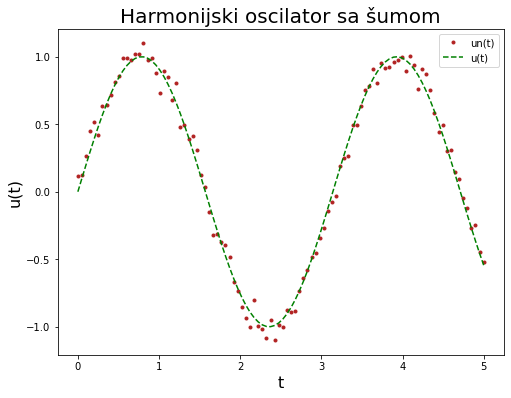

In [9]:
fig1 = plt.figure(figsize=(8,6))
plt.plot(t,un[0,:],'.',color='firebrick',label='un(t)')
plt.plot(t,u[0,:],'--',color='green',label='u(t)')
plt.title('Harmonijski oscilator sa šumom', fontsize = 20)
plt.xlabel('t', fontsize = 16)
plt.ylabel('u(t)', fontsize = 16)
plt.legend()

In [10]:
Uttn, Rn, rhs_des = build_linear_system(un, dt, dx=0, D=0, P=3, time_diff = 'poly', space_diff=None)

In [11]:
# Solve with STRidge
w = TrainSTRidge(Rn,Uttn,10**-5,1)
print("PDJ dobivena pomoću STRidge:")
print_pde(w, rhs_des)

PDJ dobivena pomoću STRidge:
u_tt = (-4.160896 +0.000000i)u
   


In [12]:
err = abs(np.array([(4 - 4.160896)/4*100]))
print("Greška dobivena koristeći PDE-FIND za identifikaciju dinamike na podatcima sa šumom:\n")
print(np.mean(err), '%')
#print("Srednja greška parametara:", np.mean(err), '%')
#print("Standardna devijacija srednje greške parametara:", np.std(err), '%')

Greška dobivena koristeći PDE-FIND za identifikaciju dinamike na podatcima sa šumom:

4.022400000000004 %
